In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pd.set_option('display.float_format', '{:.2f}'.format)

from load_data import load_data
from matplotlib.ticker import StrMethodFormatter
from settings import config

# Get the data directory from the configuration
DATA_DIR = config("DATA_DIR")

# Initial Variables

In [23]:
# TICKERS = ["BTC-USD", "ETH-USD", "SOL-USD"]
TICKERS = ["BTC-USD"]
# TICKERS = ["SOL-USD"]
# MA_DAYS = [7, 14, 21, 28, 35, 42, 49, 56]
MA_DAYS = [7]
START_DATE = "2016-01-01"
END_DATE = "2025-07-31"

In [ ]:
def load_crypto_data(
    tickers: list,
    base_directory,
    start_date: str,
    end_date: str,
) -> dict:
    """
    Loads minute-level data for multiple crypto tickers from Coinbase source.

    Parameters:
    - tickers: list of strings, e.g., ["BTC-USD", "ETH-USD", "SOL-USD"]
    - base_directory: path to your data directory (from config)
    - start_date: optional string, e.g., "2023-01-01"
    - end_date: optional string, e.g., "2023-12-31"

    Returns:
    - dict of DataFrames keyed by ticker
    """
    data = {}
    for ticker in tickers:
        df = load_data(
            base_directory=base_directory,
            ticker=ticker,
            source="Coinbase",
            asset_class="Cryptocurrencies",
            timeframe="Minute",
            file_format="pickle",
        )
        df.index = pd.to_datetime(df.index)
        df = df.sort_index()

        # Apply date filtering if specified
        if start_date:
            df = df[df.index >= pd.to_datetime(start_date)]
        if end_date:
            df = df[df.index <= pd.to_datetime(end_date)]

        data[ticker] = df

    return data

crypto_data = load_crypto_data(
    tickers=TICKERS,
    base_directory=DATA_DIR,
    start_date=START_DATE,
    end_date=END_DATE,
)

crypto_data

{'BTC-USD':                           low      high      open     close  volume
 Date                                                               
 2016-01-01 00:00:00    430.35    430.39    430.35    430.39    0.07
 2016-01-01 00:01:00    430.38    430.40    430.38    430.40    0.95
 2016-01-01 00:02:00    430.40    430.40    430.40    430.40    1.63
 2016-01-01 00:03:00    430.36    430.39    430.39    430.36   12.57
 2016-01-01 00:04:00    430.39    430.39    430.39    430.39    1.95
 ...                       ...       ...       ...       ...     ...
 2025-07-30 23:56:00 117856.59 117880.00 117856.59 117867.34    0.27
 2025-07-30 23:57:00 117836.00 117867.37 117867.35 117836.00    1.36
 2025-07-30 23:58:00 117829.75 117836.01 117836.00 117830.15    0.70
 2025-07-30 23:59:00 117830.14 117830.15 117830.15 117830.15    0.78
 2025-07-31 00:00:00 117830.15 117869.50 117830.15 117833.75    1.23
 
 [4939260 rows x 5 columns]}

In [25]:
def calculate_rsi(prices: pd.Series, period: int = 14) -> pd.Series:
    """Calculates the Relative Strength Index (RSI) for a price series."""
    delta = prices.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.ewm(alpha=1/period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [ ]:
def prepare_crypto_indicators(
    data: dict,
    rsi_period: int = 14,
    ma_days: list = [7, 14, 21, 28, 35, 42, 49, 56, 63, 70]
) -> dict:
    """
    Adds RSI and daily moving averages to each crypto DataFrame.

    Parameters:
    - data: dict of DataFrames keyed by ticker
    - rsi_period: RSI lookback (default=14)
    - ma_days: list of MA durations (in days) for trend allocation

    Returns:
    - dict of enriched DataFrames with 'RSI' and MA columns
    """
    enriched_data = {}

    for ticker, df in data.items():
        df = df.copy()
        df["RSI"] = calculate_rsi(df["close"], period=rsi_period)

        for day in ma_days:
            window = 1440 * day  # 1440 minutes in a day
            df[f"MA_{day}d"] = df["close"].rolling(window=window, min_periods=1).mean()

        enriched_data[ticker] = df

    return enriched_data



enriched_data = prepare_crypto_indicators(
    data=crypto_data,
    rsi_period=14,
    ma_days=MA_DAYS,
)

enriched_data

{'BTC-USD':                           low      high      open     close  volume    RSI  \
 Date                                                                         
 2016-01-01 00:00:00    430.35    430.39    430.35    430.39    0.07    NaN   
 2016-01-01 00:01:00    430.38    430.40    430.38    430.40    0.95 100.00   
 2016-01-01 00:02:00    430.40    430.40    430.40    430.40    1.63 100.00   
 2016-01-01 00:03:00    430.36    430.39    430.39    430.36   12.57  75.11   
 2016-01-01 00:04:00    430.39    430.39    430.39    430.39    1.95  79.28   
 ...                       ...       ...       ...       ...     ...    ...   
 2025-07-30 23:56:00 117856.59 117880.00 117856.59 117867.34    0.27  63.14   
 2025-07-30 23:57:00 117836.00 117867.37 117867.35 117836.00    1.36  58.16   
 2025-07-30 23:58:00 117829.75 117836.01 117836.00 117830.15    0.70  57.25   
 2025-07-30 23:59:00 117830.14 117830.15 117830.15 117830.15    0.78  57.25   
 2025-07-31 00:00:00 117830.15 117869.50 

In [ ]:
def backtest_rsi_multi_asset_strategy(
    data: dict,
    initial_capital: float,
    rsi_threshold: float,
    trailing_stop_pct: float,
    ma_days: list,
) -> pd.DataFrame:
    """
    Multi-asset backtest using RSI threshold + MA filter + trailing stop.
    
    Capital is shared across all assets. Each asset trades independently.

    Parameters:
    - data: dict of enriched DataFrames keyed by asset symbol (must have RSI and MA columns)
    - initial_capital: starting cash
    - rsi_threshold: RSI entry trigger (e.g., 30)
    - trailing_stop_pct: trailing stop trigger (e.g., 0.02)
    - ma_days: list of moving average day lengths

    Returns:
    - DataFrame of all trades across assets
    """
    # Merge index across all assets
    all_timestamps = sorted(set().union(*[df.index for df in data.values()]))
    
    # Initialize tracking variables
    cash = initial_capital

    # Create list for trades
    trades = []

    # Create dictionary to hold positions
    positions = {symbol: None for symbol in data}

    for timestamp in all_timestamps:
        for symbol, df in data.items():
            if timestamp not in df.index:
                continue

            row = df.loc[timestamp]
            position = positions[symbol]

            # Index of current bar; need previous bar for signals
            i = df.index.get_loc(timestamp)
            if i == 0:
                continue
            prev = df.iloc[i - 1]

            # --- ENTRY ---
            if position is None:
                # FIX: use previous-bar RSI (already did) AND previous-bar MA/close to avoid look-ahead
                prev_rsi = prev.get("RSI", float("nan"))
                if pd.isna(prev_rsi):
                    continue

                
                if prev_rsi < rsi_threshold:
                    # FIX: use previous close vs previous MA values
                    if any(pd.isna(prev.get(f"MA_{day}d", float("nan"))) for day in ma_days):
                        continue
                    ma_passes = sum(prev["close"] > prev[f"MA_{day}d"] for day in ma_days)
                    allocation_pct = ma_passes / len(ma_days)
                    if allocation_pct <= 0:
                        continue

                    # capital_to_use = cash * allocation_pct
                    capital_to_use = cash * allocation_pct / len(TICKERS)
                    if capital_to_use <= 0:
                        continue

                    entry_price = row["open"]  # execute at current open
                    if entry_price <= 0:
                        continue

                    quantity = capital_to_use / entry_price

                    positions[symbol] = {
                        "entry_time": timestamp,
                        "entry_price": float(entry_price),
                        "peak_price": float(entry_price),
                        "quantity": float(quantity),
                        "allocation_pct": float(allocation_pct),
                    }
                    cash -= quantity * entry_price

            # --- EXIT ---
            else:
                # Update peak with current bar high
                peak_price = max(position["peak_price"], row["high"])
                stop_price = peak_price * (1 - trailing_stop_pct)

                # Did price breach the stop this bar?
                if row["low"] <= stop_price:
                    # FIX: gap handling — if open < stop, assume fill at open; else at stop
                    if row["open"] < stop_price:
                        exit_price = row["open"]
                    else:
                        exit_price = stop_price

                    quantity = position["quantity"]
                    pnl = quantity * (exit_price - position["entry_price"])
                    return_dec = (exit_price - position["entry_price"]) / position["entry_price"]

                    cash += quantity * exit_price

                    trades.append({
                        "asset": symbol,
                        "entry_time": position["entry_time"],
                        "exit_time": timestamp,
                        "entry_price": position["entry_price"],
                        "exit_price": exit_price,
                        "quantity": quantity,
                        "allocation_pct": position["allocation_pct"],
                        "pnl": pnl,
                        "return_dec": return_dec,  # FIX: keep as decimal; format later
                        "cash": cash,
                    })

                    positions[symbol] = None
                else:
                    # carry forward higher peak
                    positions[symbol]["peak_price"] = peak_price

                    # Create new dataframe for trades
    trades_df = pd.DataFrame(trades)

    # If there are entries, calc cumulative pnl, equity, cumulative return
    if not trades_df.empty:
        trades_df["cumulative_pnl"] = trades_df["pnl"].cumsum()
        trades_df["equity"] = trades_df["cumulative_pnl"] + initial_capital
        trades_df["cumulative_return"] = trades_df["equity"] / initial_capital - 1

    # Export trades DataFrame
    trades_df.to_csv("multi_asset_trades.csv", index=False)

    return trades_df

trades_df = backtest_rsi_multi_asset_strategy(
    data=enriched_data,
    initial_capital=10_000,
    rsi_threshold=30,
    trailing_stop_pct=0.02,
    ma_days=MA_DAYS,
)

trades_df


In [33]:
# # Iterate through all timestamps
# for timestamp in all_timestamps:

#     # Iterate through all assets and the minute data
#     for symbol, df in data.items():

#         # If a timestamp is missing from the data in a specific asset
#         if timestamp not in df.index:
#             continue

#         # Set current row
#         row = df.loc[timestamp]

#         # Current position state
#         position = positions[symbol]

#         # --- ENTRY ---
#         # Check if there is not an existing position and if so then open a new one
#         if position is None:

#             # Index of current bar; need previous bar for signals
#             i = df.index.get_loc(timestamp)
#             if i == 0:
#                 continue

#             # Get previous RSI
#             prev_rsi = df.iloc[i - 1]["RSI"]

#             # Check previous RSI to the RSI threshold
#             if prev_rsi < rsi_threshold:

#                 # Sum the number of moving average tranches where the close price is > than the MA
#                 ma_passes = sum(row["close"] > row[f"MA_{day}d"] for day in ma_days)

#                 # Set allocation percentage based on the number of tranches
#                 allocation_pct = ma_passes * (1 / len(ma_days))

#                 # If no allocation, continue
#                 if allocation_pct == 0:
#                     continue

#                 # Set the amount of capital to use
#                 capital_to_use = cash * allocation_pct

#                 # Set entry price as the open
#                 entry_price = row["open"]

#                 # Set quantity to buy
#                 quantity = capital_to_use / entry_price

#                 # Set the position
#                 positions[symbol] = {
#                     "entry_time": timestamp,
#                     "entry_price": entry_price,
#                     "peak_price": entry_price,
#                     "quantity": quantity,
#                     "allocation_pct": allocation_pct,
#                 }

#                 # Update the current cash position
#                 cash -= quantity * entry_price

#         # --- EXIT ---
#         # Check if there is an existing position
#         elif position is not None:

#             # Find the highest price that the position had
#             peak_price = max(position["peak_price"], row["high"])

#             # Set the trailing stop based on the peak price
#             stop_price = peak_price * (1 - trailing_stop_pct)

#             # If the current low is less than the stop price
#             if row["low"] <= stop_price:

#                 # The position gets stopped out at the stop price
#                 exit_price = stop_price

#                 # Pull the quantity from the positions set
#                 quantity = position["quantity"]

#                 # Update the pnl
#                 pnl = quantity * (exit_price - position["entry_price"])

#                 # Find the percent return
#                 return_pct = (exit_price - position["entry_price"]) / position["entry_price"]

#                 # Update the current cash position
#                 cash += quantity * exit_price

#                 # Append the trade to the trades list
#                 trades.append({
#                     "asset": symbol,
#                     "entry_time": position["entry_time"],
#                     "exit_time": timestamp,
#                     "entry_price": position["entry_price"],
#                     "exit_price": exit_price,
#                     "quantity": quantity,
#                     "allocation_pct": position["allocation_pct"],
#                     "pnl": pnl,
#                     "return_pct": return_pct * 100,
#                     "cash": cash,
#                 })

#                 # Remove the position from the positions set
#                 positions[symbol] = None
#             else:
#                 # If the 
#                 positions[symbol]["peak_price"] = peak_price



In [ ]:
for timestamp in all_timestamps:
    for symbol, df in data.items():
        if timestamp not in df.index:
            continue

        row = df.loc[timestamp]
        position = positions[symbol]

        # Index of current bar; need previous bar for signals
        i = df.index.get_loc(timestamp)
        if i == 0:
            continue
        prev = df.iloc[i - 1]

        # --- ENTRY ---
        if position is None:
            # FIX: use previous-bar RSI (already did) AND previous-bar MA/close to avoid look-ahead
            prev_rsi = prev.get("RSI", float("nan"))
            if pd.isna(prev_rsi):
                continue

            
            if prev_rsi < rsi_threshold:
                # FIX: use previous close vs previous MA values
                if any(pd.isna(prev.get(f"MA_{day}d", float("nan"))) for day in ma_days):
                    continue
                ma_passes = sum(prev["close"] > prev[f"MA_{day}d"] for day in ma_days)
                allocation_pct = ma_passes / len(ma_days)
                if allocation_pct <= 0:
                    continue

                # capital_to_use = cash * allocation_pct
                capital_to_use = cash * allocation_pct / len(TICKERS)
                if capital_to_use <= 0:
                    continue

                entry_price = row["open"]  # execute at current open
                if entry_price <= 0:
                    continue

                quantity = capital_to_use / entry_price

                positions[symbol] = {
                    "entry_time": timestamp,
                    "entry_price": float(entry_price),
                    "peak_price": float(entry_price),
                    "quantity": float(quantity),
                    "allocation_pct": float(allocation_pct),
                }
                cash -= quantity * entry_price

        # --- EXIT ---
        else:
            # Update peak with current bar high
            peak_price = max(position["peak_price"], row["high"])
            stop_price = peak_price * (1 - trailing_stop_pct)

            # Did price breach the stop this bar?
            if row["low"] <= stop_price:
                # FIX: gap handling — if open < stop, assume fill at open; else at stop
                if row["open"] < stop_price:
                    exit_price = row["open"]
                else:
                    exit_price = stop_price

                quantity = position["quantity"]
                pnl = quantity * (exit_price - position["entry_price"])
                return_dec = (exit_price - position["entry_price"]) / position["entry_price"]

                cash += quantity * exit_price

                trades.append({
                    "asset": symbol,
                    "entry_time": position["entry_time"],
                    "exit_time": timestamp,
                    "entry_price": position["entry_price"],
                    "exit_price": exit_price,
                    "quantity": quantity,
                    "allocation_pct": position["allocation_pct"],
                    "pnl": pnl,
                    "return_dec": return_dec,  # FIX: keep as decimal; format later
                    "cash": cash,
                })

                positions[symbol] = None
            else:
                # carry forward higher peak
                positions[symbol]["peak_price"] = peak_price

    

# # (Optional) liquidate any open positions at the end at last available close
# last_ts = max(all_timestamps) if len(all_timestamps) else None
# if last_ts is not None:
#     for symbol, df in data.items():
#         if positions[symbol] is not None and last_ts in df.index:
#             last_close = float(df.loc[last_ts, "close"])
#             pos = positions[symbol]
#             quantity = pos["quantity"]
#             pnl = quantity * (last_close - pos["entry_price"])
#             return_dec = (last_close - pos["entry_price"]) / pos["entry_price"]
#             cash += quantity * last_close
#             trades.append({
#                 "asset": symbol,
#                 "entry_time": pos["entry_time"],
#                 "exit_time": last_ts,
#                 "entry_price": pos["entry_price"],
#                 "exit_price": last_close,
#                 "quantity": quantity,
#                 "allocation_pct": pos["allocation_pct"],
#                 "pnl": pnl,
#                 "return_dec": return_dec,
#                 "cash": cash,
#             })
#             positions[symbol] = None

In [35]:
# def compute_capped_shares(weights, max_share=0.5):
#     """
#     Given positive weights (list/array), return allocation shares that:
#       - are proportional to weights,
#       - sum to <= 1,
#       - and each <= max_share.
#     If the cap prevents using all cash, leftover stays as cash.
#     """
#     import math
#     n = len(weights)
#     if n == 0:
#         return []

#     # Guard: nonpositive weights -> zero shares
#     if all((w is None) or (not math.isfinite(w)) or (w <= 0) for w in weights):
#         return [0.0] * n

#     # Normalize base shares
#     w = [0.0 if (w is None or not math.isfinite(w) or w <= 0) else float(w) for w in weights]
#     total_w = sum(w)
#     base = [wi / total_w for wi in w]

#     # Water-filling with cap
#     capped = [0.0] * n
#     remaining = set(range(n))
#     remaining_share = 1.0
#     remaining_weight = 1.0  # since base sums to 1

#     # Iterate until all remaining are within cap or nothing left to distribute
#     while remaining and remaining_share > 1e-12 and remaining_weight > 0:
#         # Tentative shares proportional to base within remaining pool
#         # (base[i] / remaining_weight) is each one's fraction of the remaining pool
#         clipped_any = False
#         tentative = {}
#         for i in list(remaining):
#             share_i = (base[i] / remaining_weight) * remaining_share
#             if share_i > max_share + 1e-12:
#                 # clip
#                 capped[i] = max_share
#                 remaining_share -= max_share
#                 remaining_weight -= base[i]
#                 remaining.remove(i)
#                 clipped_any = True
#             else:
#                 tentative[i] = share_i

#         if not clipped_any:
#             # No more clipping needed; assign tentatives and finish
#             for i, s in tentative.items():
#                 capped[i] = s
#             remaining.clear()

#     # If for numerical reasons we still have a tiny pool, leave it as cash (capped sums <= 1).
#     return capped


In [36]:
# # This handles multiple assets trading at the same time with a maximum cash share cap

# for timestamp in all_timestamps:

#     # -----------------------
#     # 1) EXITS (all symbols)
#     # -----------------------
#     for symbol, df in data.items():
#         if timestamp not in df.index:
#             continue
#         row = df.loc[timestamp]
#         position = positions[symbol]
#         if position is None:
#             continue

#         # trailing stop update
#         peak_price = max(position["peak_price"], row["high"])
#         stop_price = peak_price * (1 - trailing_stop_pct)

#         if row["low"] <= stop_price:
#             # gap handling: fill at open if open < stop, else at stop
#             exit_price = row["open"] if row["open"] < stop_price else stop_price
#             qty = position["quantity"]
#             pnl = qty * (exit_price - position["entry_price"])
#             ret_dec = (exit_price - position["entry_price"]) / position["entry_price"]

#             cash += qty * exit_price
#             trades.append({
#                 "asset": symbol,
#                 "entry_time": position["entry_time"],
#                 "exit_time": timestamp,
#                 "entry_price": position["entry_price"],
#                 "exit_price": exit_price,
#                 "quantity": qty,
#                 "allocation_pct": position["allocation_pct"],
#                 "pnl": pnl,
#                 "return_dec": ret_dec,
#                 "cash": cash,
#             })
#             positions[symbol] = None
#         else:
#             positions[symbol]["peak_price"] = peak_price

#     # -----------------------
#     # 2) ENTRIES (batch)
#     # -----------------------
#     # Collect all candidates that signal on the previous bar; weight by MA passes
#     candidates = []
#     for symbol, df in data.items():
#         if timestamp not in df.index:
#             continue
#         if positions[symbol] is not None:
#             continue

#         i = df.index.get_loc(timestamp)
#         if i == 0:
#             continue
#         prev = df.iloc[i - 1]
#         row = df.iloc[i]  # current bar (same as df.loc[timestamp])

#         prev_rsi = prev.get("RSI")
#         if pd.isna(prev_rsi) or prev_rsi >= rsi_threshold:
#             continue

#         # require all MA values on prev bar
#         if any(pd.isna(prev.get(f"MA_{day}d")) for day in ma_days):
#             continue

#         ma_passes = sum(prev["close"] > prev[f"MA_{day}d"] for day in ma_days)
#         weight = ma_passes / len(ma_days)
#         if weight <= 0:
#             continue

#         entry_price = float(row["open"])
#         if entry_price <= 0:
#             continue

#         candidates.append({
#             "symbol": symbol,
#             "entry_price": entry_price,
#             "weight": float(weight),
#             "timestamp": timestamp,
#         })

#     # Split cash proportionally across all candidates (based on starting cash)
#     max_share = 1  # e.g., no single asset gets more than 50% of starting cash at this timestamp

# # ... build `candidates` as before, each with fields: symbol, entry_price, weight, timestamp

#     if candidates and cash > 0:
#         starting_cash = cash
#         weights = [c["weight"] for c in candidates]
#         shares = compute_capped_shares(weights, max_share=max_share)

#         entries_to_open = []
#         total_cash_spent = 0.0

#         for c, share in zip(candidates, shares):
#             capital_to_use = starting_cash * share
#             if capital_to_use <= 0:
#                 continue
#             qty = capital_to_use / c["entry_price"]
#             if qty <= 0:
#                 continue
#             entries_to_open.append((c["symbol"], c["timestamp"], c["entry_price"], qty, c["weight"]))
#             total_cash_spent += qty * c["entry_price"]

#         # Place all entries off the starting cash baseline
#         for symbol, ts, price, qty, weight in entries_to_open:
#             positions[symbol] = {
#                 "entry_time": ts,
#                 "entry_price": float(price),
#                 "peak_price": float(price),
#                 "quantity": float(qty),
#                 "allocation_pct": float(weight),  # keep your pre-cap tranche metric if you like
#             }

#         cash -= total_cash_spent  # any unused (due to caps) remains as cash


# # --- END-OF-PERIOD LIQUIDATION (optional) ---
# # If you want to force flat at the end of the test window.
# for symbol, df in data.items():
#     pos = positions.get(symbol)
#     if pos is None:
#         continue

#     # Choose the last timestamp you have for this asset (safer than assuming a global last_ts)
#     last_ts_asset = df.index[-1]
#     last_close = float(df.loc[last_ts_asset, "close"])

#     qty = float(pos["quantity"])
#     exit_price = last_close
#     pnl = qty * (exit_price - pos["entry_price"])
#     ret_dec = (exit_price - pos["entry_price"]) / pos["entry_price"]

#     cash += qty * exit_price
#     trades.append({
#         "asset": symbol,
#         "entry_time": pos["entry_time"],
#         "exit_time": last_ts_asset,
#         "entry_price": float(pos["entry_price"]),
#         "exit_price": exit_price,
#         "quantity": qty,
#         "allocation_pct": float(pos["allocation_pct"]),
#         "pnl": pnl,
#         "return_dec": ret_dec,
#         "cash": cash,
#     })

#     positions[symbol] = None  # clear it

In [ ]:
# Create new dataframe for trades
trades_df = pd.DataFrame(trades)

# If there are entries, calc cumulative pnl, equity, cumulative return
if not trades_df.empty:
    trades_df["cumulative_pnl"] = trades_df["pnl"].cumsum()
    trades_df["equity"] = trades_df["cumulative_pnl"] + initial_capital
    trades_df["cumulative_return"] = trades_df["equity"] / initial_capital - 1

# Export trades DataFrame
trades_df.to_csv("multi_asset_trades.csv", index=False)

trades_df

# trades_df = backtest_rsi_multi_asset_strategy(
#     data=enriched_data,
#     initial_capital=100_000,
#     rsi_threshold=30,
#     trailing_stop_pct=0.02,
#     ma_days=MA_DAYS,
# )

# trades_df

,asset,entry_time,exit_time,entry_price,exit_price,quantity,allocation_pct,pnl,return_dec,cash,cumulative_pnl,equity,cumulative_return
0,BTC-USD,2016-01-01 06:03:00,2016-01-03 13:45:00,435.63,428.81,22.96,1.00,-156.58,-0.02,9843.42,-156.58,9843.42,-0.02
1,BTC-USD,2016-01-04 08:45:00,2016-01-08 07:16:00,434.04,455.11,22.68,1.00,477.88,0.05,10321.30,321.30,10321.30,0.03
2,BTC-USD,2016-01-08 07:17:00,2016-01-08 18:06:00,455.10,449.43,22.68,1.00,-128.64,-0.01,10192.66,192.66,10192.66,0.02
3,BTC-USD,2016-01-08 18:07:00,2016-01-10 00:53:00,448.51,446.88,22.73,1.00,-37.04,-0.00,10155.62,155.62,10155.62,0.02
4,BTC-USD,2016-01-10 00:54:00,2016-01-12 23:50:00,445.69,443.60,22.79,1.00,-47.69,-0.00,10107.93,107.93,10107.93,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3929,BTC-USD,2025-07-22 12:33:00,2025-07-22 14:50:00,119119.70,117284.32,59.36,1.00,-108956.76,-0.02,6962556.44,6952556.44,6962556.44,695.26
3930,BTC-USD,2025-07-22 17:12:00,2025-07-23 10:10:00,118489.49,117894.00,58.76,1.00,-34991.57,-0.01,6927564.88,6917564.88,6927564.88,691.76
3931,BTC-USD,2025-07-24 02:25:00,2025-07-25 02:12:00,118849.99,117166.55,58.29,1.00,-98125.10,-0.01,6829439.78,6819439.78,6829439.78,681.94
3932,BTC-USD,2025-07-26 20:19:00,2025-07-28 18:20:00,118109.69,117442.22,57.82,1.00,-38595.02,-0.01,6790844.75,6780844.75,6790844.75,678.08


In [38]:
# def backtest_rsi_multi_asset_strategy(
#     data: dict,
#     initial_capital: float,
#     rsi_threshold: float,
#     trailing_stop_pct: float,
#     ma_days: list,
# ) -> pd.DataFrame:
#     """
#     Multi-asset backtest using RSI threshold + MA filter + trailing stop.
    
#     Capital is shared across all assets. Each asset trades independently.

#     Parameters:
#     - data: dict of enriched DataFrames keyed by asset symbol (must have RSI and MA columns)
#     - initial_capital: starting cash
#     - rsi_threshold: RSI entry trigger (e.g., 30)
#     - trailing_stop_pct: trailing stop trigger (e.g., 0.02)
#     - ma_days: list of moving average day lengths

#     Returns:
#     - DataFrame of all trades across assets
#     """
#     # Merge index across all assets
#     all_timestamps = sorted(set().union(*[df.index for df in data.values()]))
    
#     # Initialize tracking variables
#     cash = initial_capital
#     trades = []
#     positions = {symbol: None for symbol in data}
    
#     # Prep asset DataFrames
#     for df in data.values():
#         df.sort_index(inplace=True)

#     for timestamp in all_timestamps:
#         for symbol, df in data.items():
#             if timestamp not in df.index:
#                 continue

#             row = df.loc[timestamp]

#             # Current position state
#             position = positions[symbol]

#             # --- ENTRY ---
#             if position is None:
#                 # Need previous RSI point to trigger
#                 i = df.index.get_loc(timestamp)
#                 if i == 0:
#                     continue
#                 prev_rsi = df.iloc[i - 1]["RSI"]

#                 if prev_rsi < rsi_threshold:
#                     ma_passes = sum(row["close"] > row[f"MA_{day}d"] for day in ma_days)
#                     allocation_pct = ma_passes * (1 / len(ma_days))
#                     if allocation_pct == 0:
#                         continue

#                     capital_to_use = cash * allocation_pct
#                     entry_price = row["open"]
#                     quantity = capital_to_use / entry_price

#                     positions[symbol] = {
#                         "entry_time": timestamp,
#                         "entry_price": entry_price,
#                         "peak_price": entry_price,
#                         "quantity": quantity,
#                         "allocation_pct": allocation_pct,
#                     }

#                     cash -= quantity * entry_price

#             # --- EXIT ---
#             elif position is not None:
#                 peak_price = max(position["peak_price"], row["high"])
#                 stop_price = peak_price * (1 - trailing_stop_pct)

#                 if row["low"] <= stop_price:
#                     exit_price = stop_price
#                     quantity = position["quantity"]
#                     pnl = quantity * (exit_price - position["entry_price"])
#                     return_pct = (exit_price - position["entry_price"]) / position["entry_price"]

#                     cash += quantity * exit_price

#                     trades.append({
#                         "asset": symbol,
#                         "entry_time": position["entry_time"],
#                         "exit_time": timestamp,
#                         "entry_price": position["entry_price"],
#                         "exit_price": exit_price,
#                         "quantity": quantity,
#                         "allocation_pct": position["allocation_pct"],
#                         "pnl": pnl,
#                         "return_pct": return_pct * 100,
#                         "cash": cash,
#                     })

#                     positions[symbol] = None
#                 else:
#                     positions[symbol]["peak_price"] = peak_price

#     trades_df = pd.DataFrame(trades)
#     if not trades_df.empty:
#         trades_df["cumulative_pnl"] = trades_df["pnl"].cumsum()
#         trades_df["equity"] = trades_df["cumulative_pnl"] + initial_capital
#         trades_df["cumulative_return"] = trades_df["equity"] / initial_capital - 1

#     # Export trades DataFrame
#     trades_df.to_csv("multi_asset_trades.csv", index=False)

#     return trades_df

# trades_df = backtest_rsi_multi_asset_strategy(
#     data=enriched_data,
#     initial_capital=100_000,
#     rsi_threshold=30,
#     trailing_stop_pct=0.02,
#     ma_days=MA_DAYS,
# )

# trades_df

In [39]:
# def compute_daily_performance(
#     trades: pd.DataFrame,
#     data: dict,
# ) -> pd.DataFrame:
#     """
#     Computes daily portfolio equity and return from multi-asset trades and prices.

#     Parameters:
#     - trades: DataFrame of trades from backtest_rsi_multi_asset_strategy
#     - data: dict of price DataFrames per asset (with 'close'), indexed by datetime

#     Returns:
#     - DataFrame indexed by date with:
#         - equity
#         - cash
#         - daily_return
#         - cumulative_return
#         - [position_{asset}]
#         - [price_{asset}]
#     """

In [40]:
# Filter the entry trades
entry_trades_df = trades_df.copy()
entry_trades_df = entry_trades_df[['asset', 'entry_time', 'entry_price', 'quantity']]
entry_trades_df['cash'] = entry_trades_df['entry_price'] * entry_trades_df['quantity'] * -1
entry_trades_df['crypto_value'] = entry_trades_df['quantity'] * entry_trades_df['entry_price']
entry_trades_df.rename(columns={'entry_time': 'Date'}, inplace=True)

entry_trades_df

,asset,Date,entry_price,quantity,cash,crypto_value
0,BTC-USD,2016-01-01 06:03:00,435.63,22.96,-10000.00,10000.00
1,BTC-USD,2016-01-04 08:45:00,434.04,22.68,-9843.42,9843.42
2,BTC-USD,2016-01-08 07:17:00,455.10,22.68,-10321.30,10321.30
3,BTC-USD,2016-01-08 18:07:00,448.51,22.73,-10192.66,10192.66
4,BTC-USD,2016-01-10 00:54:00,445.69,22.79,-10155.62,10155.62
...,...,...,...,...,...,...
3929,BTC-USD,2025-07-22 12:33:00,119119.70,59.36,-7071513.21,7071513.21
3930,BTC-USD,2025-07-22 17:12:00,118489.49,58.76,-6962556.44,6962556.44
3931,BTC-USD,2025-07-24 02:25:00,118849.99,58.29,-6927564.88,6927564.88
3932,BTC-USD,2025-07-26 20:19:00,118109.69,57.82,-6829439.78,6829439.78


In [41]:
# Filter the exit trades
exit_trades_df = trades_df.copy()
exit_trades_df = exit_trades_df[['asset', 'exit_time', 'exit_price', 'quantity']]
exit_trades_df['cash'] = exit_trades_df['exit_price'] * exit_trades_df['quantity']
exit_trades_df['quantity'] = exit_trades_df['quantity'] * -1  # Convert quantity to negative for exit
exit_trades_df['crypto_value'] = exit_trades_df['quantity'] * exit_trades_df['exit_price']
exit_trades_df.rename(columns={'exit_time': 'Date'}, inplace=True)

exit_trades_df

,asset,Date,exit_price,quantity,cash,crypto_value
0,BTC-USD,2016-01-03 13:45:00,428.81,-22.96,9843.42,-9843.42
1,BTC-USD,2016-01-08 07:16:00,455.11,-22.68,10321.30,-10321.30
2,BTC-USD,2016-01-08 18:06:00,449.43,-22.68,10192.66,-10192.66
3,BTC-USD,2016-01-10 00:53:00,446.88,-22.73,10155.62,-10155.62
4,BTC-USD,2016-01-12 23:50:00,443.60,-22.79,10107.93,-10107.93
...,...,...,...,...,...,...
3929,BTC-USD,2025-07-22 14:50:00,117284.32,-59.36,6962556.44,-6962556.44
3930,BTC-USD,2025-07-23 10:10:00,117894.00,-58.76,6927564.88,-6927564.88
3931,BTC-USD,2025-07-25 02:12:00,117166.55,-58.29,6829439.78,-6829439.78
3932,BTC-USD,2025-07-28 18:20:00,117442.22,-57.82,6790844.75,-6790844.75


In [42]:
# Combine entry and exit trades into a single DataFrame
ledger_events_df = pd.concat([entry_trades_df, exit_trades_df], ignore_index=True)
ledger_events_df = ledger_events_df.sort_values('Date')

ledger_events_df

,asset,Date,entry_price,quantity,cash,crypto_value,exit_price
0,BTC-USD,2016-01-01 06:03:00,435.63,22.96,-10000.00,10000.00,NaN
3934,BTC-USD,2016-01-03 13:45:00,NaN,-22.96,9843.42,-9843.42,428.81
1,BTC-USD,2016-01-04 08:45:00,434.04,22.68,-9843.42,9843.42,NaN
3935,BTC-USD,2016-01-08 07:16:00,NaN,-22.68,10321.30,-10321.30,455.11
2,BTC-USD,2016-01-08 07:17:00,455.10,22.68,-10321.30,10321.30,NaN
...,...,...,...,...,...,...,...
7865,BTC-USD,2025-07-25 02:12:00,NaN,-58.29,6829439.78,-6829439.78,117166.55
3932,BTC-USD,2025-07-26 20:19:00,118109.69,57.82,-6829439.78,6829439.78,NaN
7866,BTC-USD,2025-07-28 18:20:00,NaN,-57.82,6790844.75,-6790844.75,117442.22
3933,BTC-USD,2025-07-29 08:30:00,118793.24,57.17,-6790844.75,6790844.75,NaN


In [43]:
# Create pivot table for quantity
quantity_df = ledger_events_df.pivot_table(
    index='Date',
    columns='asset',
    values='quantity',
    aggfunc='sum',
).fillna(0)

quantity_df.columns = [f"{col}_qty" for col in quantity_df.columns]

# Cash flow dataframe
cash_df = ledger_events_df.groupby('Date')['cash'].sum().to_frame()

# Combine quantity and cash dataframes into the ledger
ledger_qtys_df = pd.concat([quantity_df, cash_df], axis=1).fillna(0)
ledger_qtys_df = ledger_qtys_df.sort_index()

ledger_qtys_df

,BTC-USD_qty,cash
Date,,
2016-01-01 06:03:00,22.96,-10000.00
2016-01-03 13:45:00,-22.96,9843.42
2016-01-04 08:45:00,22.68,-9843.42
2016-01-08 07:16:00,-22.68,10321.30
2016-01-08 07:17:00,22.68,-10321.30
...,...,...
2025-07-25 02:12:00,-58.29,6829439.78
2025-07-26 20:19:00,57.82,-6829439.78
2025-07-28 18:20:00,-57.82,6790844.75


In [44]:
# Step 1: Extract end-of-day close prices for each asset
daily_prices = []

for ticker, df in crypto_data.items():
    # daily_close = df["close"].resample("D").last().to_frame(name=f"{ticker}_price")
    daily_close = df["close"].to_frame(name=f"{ticker}_close")
    daily_prices.append(daily_close)

# Step 2: Merge all daily prices into a single DataFrame
price_df = pd.concat(daily_prices, axis=1)

price_df

,BTC-USD_close
Date,
2016-01-01 00:00:00,430.39
2016-01-01 00:01:00,430.40
2016-01-01 00:02:00,430.40
2016-01-01 00:03:00,430.36
2016-01-01 00:04:00,430.39
...,...
2025-07-30 23:56:00,117867.34
2025-07-30 23:57:00,117836.00
2025-07-30 23:58:00,117830.15


In [45]:
# Merge close prices into the ledger
ledger_qtys_prices_df = ledger_qtys_df.merge(price_df, left_index=True, right_index=True, how="outer")
ledger_qtys_prices_df.reset_index(inplace=True)
ledger_qtys_prices_df.rename(columns={'index': 'Date'}, inplace=True)

# Replace all NaN values with 0
ledger_qtys_prices_df.fillna(0, inplace=True)

# Add columns for each asset's cumulative quantity
quantity_cols = [col for col in ledger_qtys_prices_df.columns if col.endswith("_qty")]
for col in quantity_cols:
    ledger_qtys_prices_df[col] = ledger_qtys_prices_df[col].cumsum()

# Cumulative cash column
ledger_qtys_prices_df['cash'] = ledger_qtys_prices_df['cash'].cumsum()

# Add 100,000 to cash to represent initial capital
ledger_qtys_prices_df['cash'] += initial_capital

# Establish position columns for each asset
ledger_qtys_prices_pos_df = ledger_qtys_prices_df.copy()
for col in quantity_cols:
    asset_name = col.replace("_qty", "")
    ledger_qtys_prices_pos_df[f"{asset_name}_position"] = ledger_qtys_prices_pos_df[col] * ledger_qtys_prices_pos_df[f"{asset_name}_close"]

# Re-arrange the columns to have date, cash, then quantities, prices, positions grouped by asset
cols = (['Date', 'cash'] + [col for ticker in TICKERS for col in ledger_qtys_prices_pos_df.columns if col.startswith(ticker.split('-')[0])])
ledger_qtys_prices_pos_df = ledger_qtys_prices_pos_df[cols]


# Calculate total portfolio value
ledger_qtys_prices_pos_df['equity'] = ledger_qtys_prices_pos_df['cash'] + ledger_qtys_prices_pos_df[[col for col in ledger_qtys_prices_pos_df.columns if col.endswith('_position')]].sum(axis=1)

ledger_qtys_prices_pos_df

,Date,cash,BTC-USD_qty,BTC-USD_close,BTC-USD_position,equity
0,2016-01-01 00:00:00,10000.00,0.00,430.39,0.00,10000.00
1,2016-01-01 00:01:00,10000.00,0.00,430.40,0.00,10000.00
2,2016-01-01 00:02:00,10000.00,0.00,430.40,0.00,10000.00
3,2016-01-01 00:03:00,10000.00,0.00,430.36,0.00,10000.00
4,2016-01-01 00:04:00,10000.00,0.00,430.39,0.00,10000.00
...,...,...,...,...,...,...
4939255,2025-07-30 23:56:00,6670812.60,0.00,117867.34,0.00,6670812.60
4939256,2025-07-30 23:57:00,6670812.60,0.00,117836.00,0.00,6670812.60
4939257,2025-07-30 23:58:00,6670812.60,0.00,117830.15,0.00,6670812.60
4939258,2025-07-30 23:59:00,6670812.60,0.00,117830.15,0.00,6670812.60


In [46]:
# Set the 'Date' column as the index
ledger_qtys_prices_pos_df = ledger_qtys_prices_pos_df.set_index('Date')

# Step 3: Reindex ledger to daily frequency (if not already)
daily_ledger_qtys_prices_pos_df = ledger_qtys_prices_pos_df.copy()
daily_ledger_qtys_prices_pos_df = daily_ledger_qtys_prices_pos_df.resample("D").last()

daily_ledger_qtys_prices_pos_df

,cash,BTC-USD_qty,BTC-USD_close,BTC-USD_position,equity
Date,,,,,
2016-01-01,0.00,22.96,435.66,10000.69,10000.69
2016-01-02,0.00,22.96,435.40,9994.72,9994.72
2016-01-03,9843.42,0.00,431.91,0.00,9843.42
2016-01-04,0.00,22.68,433.85,9839.11,9839.11
2016-01-05,0.00,22.68,433.34,9827.54,9827.54
...,...,...,...,...,...
2025-07-27,0.00,57.82,119465.52,6907837.74,6907837.74
2025-07-28,6790844.75,0.00,118070.59,0.00,6790844.75
2025-07-29,0.00,57.17,117933.39,6741691.22,6741691.22


In [47]:
# Drop the columns where any of the crypto asset prices = 0
price_cols = [col for col in daily_ledger_qtys_prices_pos_df.columns if col.endswith("_close")]
complete_ledger = daily_ledger_qtys_prices_pos_df[~(daily_ledger_qtys_prices_pos_df[price_cols] == 0).any(axis=1)]

complete_ledger

,cash,BTC-USD_qty,BTC-USD_close,BTC-USD_position,equity
Date,,,,,
2016-01-01,0.00,22.96,435.66,10000.69,10000.69
2016-01-02,0.00,22.96,435.40,9994.72,9994.72
2016-01-03,9843.42,0.00,431.91,0.00,9843.42
2016-01-04,0.00,22.68,433.85,9839.11,9839.11
2016-01-05,0.00,22.68,433.34,9827.54,9827.54
...,...,...,...,...,...
2025-07-27,0.00,57.82,119465.52,6907837.74,6907837.74
2025-07-28,6790844.75,0.00,118070.59,0.00,6790844.75
2025-07-29,0.00,57.17,117933.39,6741691.22,6741691.22


In [48]:
# Calculate crypto daily return, cumulative return, and drawdown
qty_cols = [col for col in complete_ledger.columns if col.endswith("_qty")]
# asset_symbols = [col.replace("_qty", "") for col in qty_cols]
# for col in asset_symbols:
for col in TICKERS:
    complete_ledger[f"{col}_return"] = complete_ledger[f"{col}_close"].pct_change()
    complete_ledger[f"{col}_cum_return"] = (1 + complete_ledger[f"{col}_return"]).cumprod() - 1
    complete_ledger[f"{col}_drawdown"] = (complete_ledger[f"{col}_close"] - complete_ledger[f"{col}_close"].cummax()) / complete_ledger[f"{col}_close"].cummax()

# Calculate portfolio daily return and cumulative return
complete_ledger['Return'] = complete_ledger['equity'].pct_change()
complete_ledger['Cum_Return'] = (1 + complete_ledger['Return']).cumprod() - 1

# Calculate drawdown
complete_ledger["Drawdown"] = (complete_ledger["equity"] - complete_ledger["equity"].cummax()) / complete_ledger["equity"].cummax()

complete_ledger

/tmp/ipykernel_164266/1910673151.py:6: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  complete_ledger[f"{col}_return"] = complete_ledger[f"{col}_close"].pct_change()
/tmp/ipykernel_164266/1910673151.py:11: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  complete_ledger['Return'] = complete_ledger['equity'].pct_change()


,cash,BTC-USD_qty,BTC-USD_close,BTC-USD_position,equity,BTC-USD_return,BTC-USD_cum_return,BTC-USD_drawdown,Return,Cum_Return,Drawdown
Date,,,,,,,,,,,
2016-01-01,0.00,22.96,435.66,10000.69,10000.69,NaN,NaN,0.00,NaN,NaN,0.00
2016-01-02,0.00,22.96,435.40,9994.72,9994.72,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00
2016-01-03,9843.42,0.00,431.91,0.00,9843.42,-0.01,-0.01,-0.01,-0.02,-0.02,-0.02
2016-01-04,0.00,22.68,433.85,9839.11,9839.11,0.00,-0.00,-0.00,-0.00,-0.02,-0.02
2016-01-05,0.00,22.68,433.34,9827.54,9827.54,-0.00,-0.01,-0.01,-0.00,-0.02,-0.02
...,...,...,...,...,...,...,...,...,...,...,...
2025-07-27,0.00,57.82,119465.52,6907837.74,6907837.74,0.01,273.22,-0.00,0.01,689.74,-0.20
2025-07-28,6790844.75,0.00,118070.59,0.00,6790844.75,-0.01,270.02,-0.02,-0.02,678.04,-0.21
2025-07-29,0.00,57.17,117933.39,6741691.22,6741691.22,-0.00,269.70,-0.02,-0.01,673.12,-0.21


In [49]:
perf_df = complete_ledger
data = enriched_data
title = f"Multi-Asset Strategy: Crypto RSI < {rsi_threshold} + MA Filter + {trailing_stop_pct * 100}% Trailing Stop + Dynamic BTC, ETH, and SOL Allocation"

# Plots

/tmp/ipykernel_164266/1082134499.py:112: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/jared/python-virtual-envs/general_313/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


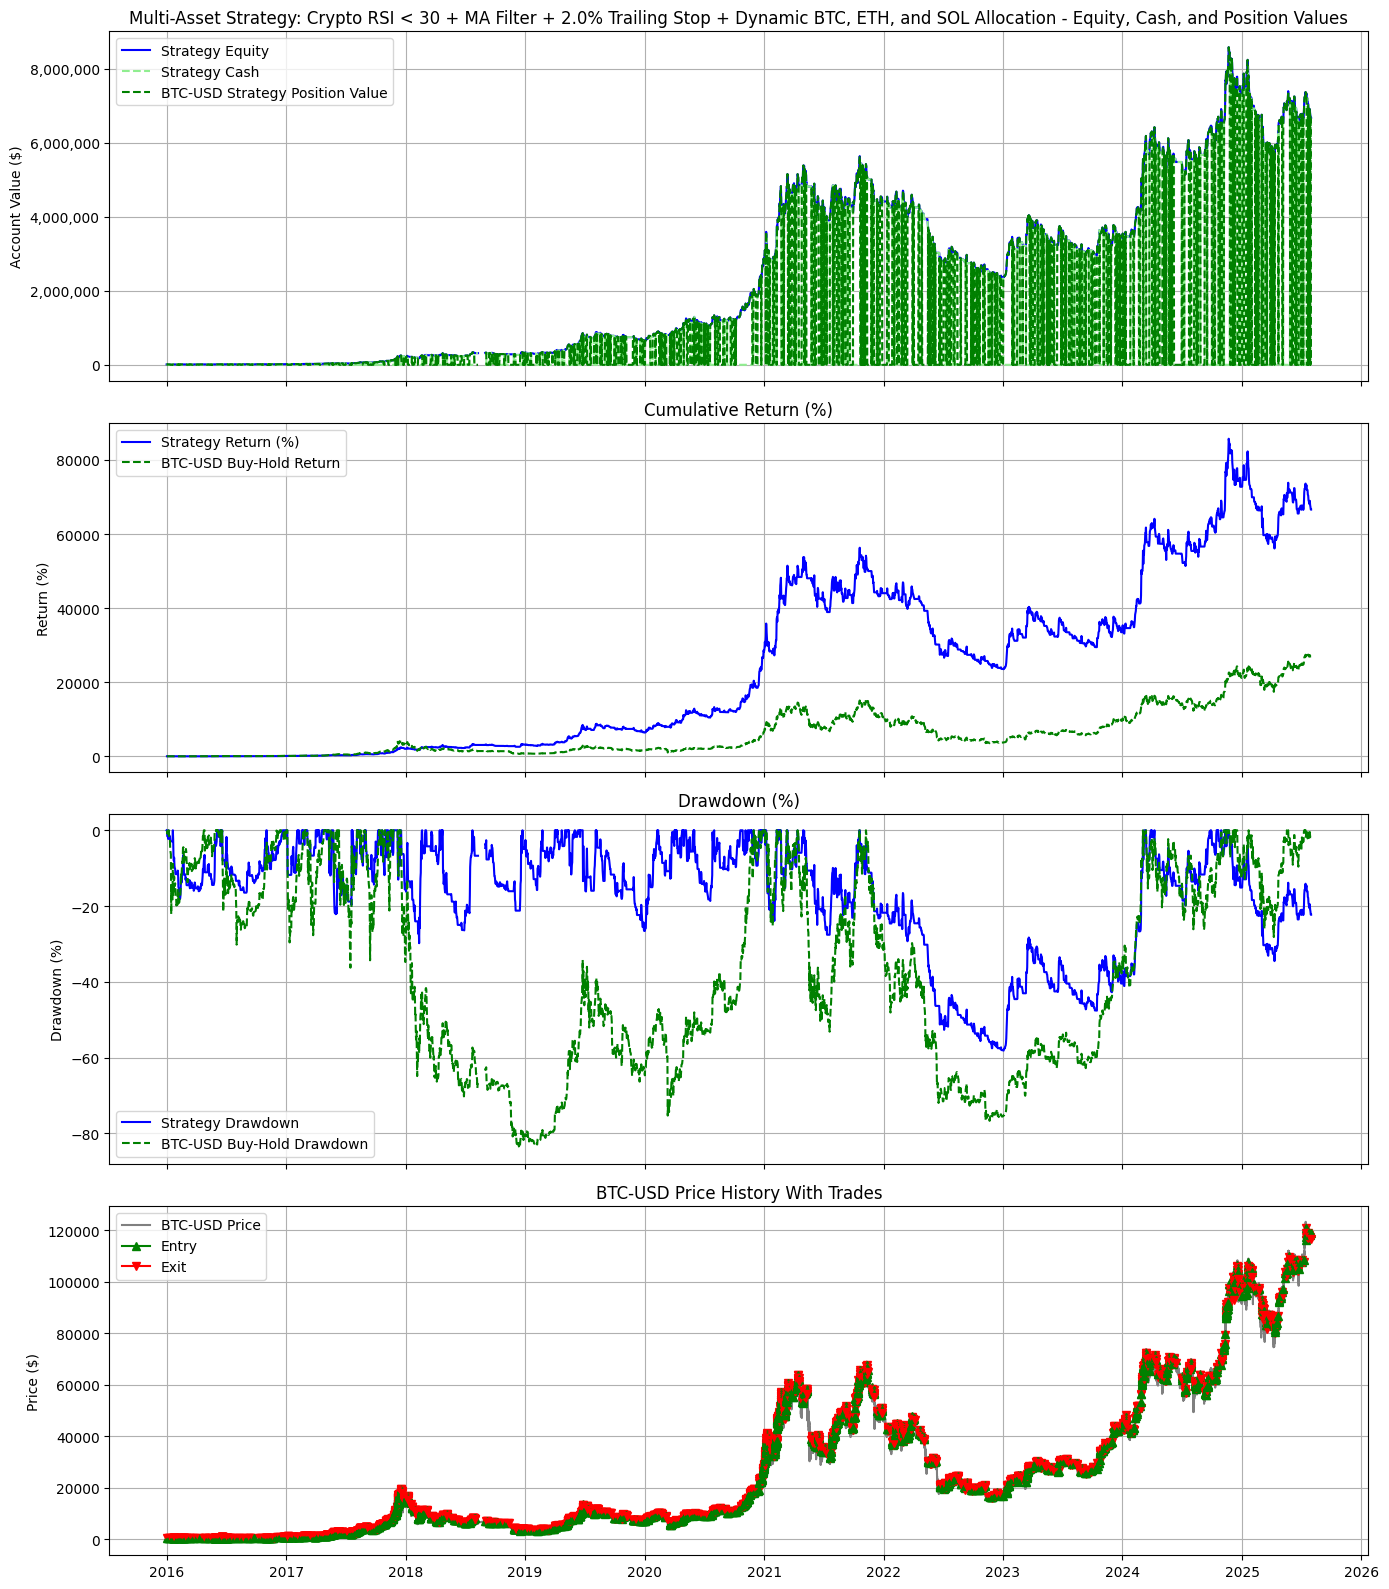

In [50]:
# def plot_multi_asset_equity_and_drawdown(
#     perf_df: pd.DataFrame,
#     trades: pd.DataFrame,
#     data: dict,
#     title: str = "Multi-Asset Strategy Performance"
# ) -> None:
"""
Plots:
- Total equity, cash, and per-asset position values
- Cumulative returns (strategy and crypto assets)
- Drawdowns (strategy and crypto assets)
- Price series and trade markers for BTC, ETH, SOL
"""

perf_df = perf_df.copy()
trades = trades_df.copy()
data = enriched_data

# Identify asset symbols
qty_cols = [col for col in perf_df.columns if col.endswith("_qty")]
asset_symbols = [col.replace("_qty", "") for col in qty_cols]

# # Compute position values and crypto drawdowns
colors = ["green", "red", "purple", "orange", "yellow"]

# # Setup plot
# fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(
#     6, 1, figsize=(14, 16), sharex=True, gridspec_kw={"height_ratios": [1, 1, 1, 1, 1, 1]}
# )

# Determine number of subplots
n_fixed = 3  # ax1, ax2, ax3
n_tickers = len(TICKERS)
total_axes = n_fixed + n_tickers

# Setup plot
fig, axes = plt.subplots(
    total_axes, 1,
    figsize=(14, 4 * total_axes),
    sharex=True,
    gridspec_kw={"height_ratios": [1] * total_axes}
)

# Unpack fixed axes
ax1, ax2, ax3 = axes[:3]

# Assign price axes
price_axes = axes[3:]

# ax1: Equity, Cash, and Position Values
ax1.plot(perf_df.index, perf_df["equity"], color="blue", label="Strategy Equity")
ax1.plot(perf_df.index, perf_df["cash"], color="lightgreen", linestyle="--", label="Strategy Cash")
# for i, symbol in enumerate(asset_symbols):
for i, symbol in enumerate(TICKERS):
    ax1.plot(perf_df.index, perf_df[f"{symbol}_position"], linestyle="--", color=colors[i % len(colors)], label=f"{symbol} Strategy Position Value")
ax1.set_title(f"{title} - Equity, Cash, and Position Values")
ax1.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
ax1.set_ylabel("Account Value ($)")
ax1.legend()
ax1.grid(True)

# ax2: Cumulative Returns
ax2.plot(perf_df.index, perf_df["Cum_Return"] * 100, color="blue", label="Strategy Return (%)")
# for i, symbol in enumerate(asset_symbols):
for i, symbol in enumerate(TICKERS):
    ax2.plot(perf_df.index, perf_df[f"{symbol}_cum_return"] * 100, linestyle="--", color=colors[i % len(colors)], label=f"{symbol} Buy-Hold Return")
ax2.set_title("Cumulative Return (%)")
ax2.set_ylabel("Return (%)")
ax2.legend()
ax2.grid(True)

# ax3: Drawdowns
ax3.plot(perf_df.index, perf_df["Drawdown"] * 100, color="blue", label="Strategy Drawdown")
# for i, symbol in enumerate(asset_symbols):
for i, symbol in enumerate(TICKERS):
    ax3.plot(perf_df.index, perf_df[f"{symbol}_drawdown"] * 100, linestyle="--", color=colors[i % len(colors)], label=f"{symbol} Buy-Hold Drawdown")
ax3.set_title("Drawdown (%)")
ax3.set_ylabel("Drawdown (%)")
ax3.legend()
ax3.grid(True)

# ax4, ax5, ax6... : Price plots with trade markers are dynamically created based on the number of crypto assets
for i, symbol in enumerate(TICKERS):
    df = data[symbol].copy()
    df.index = pd.to_datetime(df.index)
    plot_df = df[df.index >= trades["entry_time"].min()]
    ax = price_axes[i]
    ax.plot(plot_df.index, plot_df["close"], color="gray", label=f"{symbol} Price")

    # Mark trades
    asset_trades = trades[trades["asset"] == symbol]
    for _, trade in asset_trades.iterrows():
        if trade['quantity'] > 0:
            entry_time = trade["entry_time"]
            exit_time = trade["exit_time"]
            if entry_time in plot_df.index:
                ax.plot(entry_time, plot_df.loc[entry_time, "close"], marker="^", color="green", label="Entry" if "Entry" not in ax.get_legend_handles_labels()[1] else "")
            if exit_time in plot_df.index:
                ax.plot(exit_time, plot_df.loc[exit_time, "close"], marker="v", color="red", label="Exit" if "Exit" not in ax.get_legend_handles_labels()[1] else "")
        else:
            entry_time = trade["entry_time"]
            exit_time = trade["exit_time"]
            if entry_time in plot_df.index:
                ax.plot(entry_time, plot_df.loc[entry_time, "close"], marker="^", color="lightgreen", label="Entry (No trade due to position conflict)" if "Entry (No trade due to position conflict)" not in ax.get_legend_handles_labels()[1] else "")
            if exit_time in plot_df.index:
                ax.plot(exit_time, plot_df.loc[exit_time, "close"], marker="v", color="pink", label="Exit (No trade due to position conflict)" if "Exit (No trade due to position conflict)" not in ax.get_legend_handles_labels()[1] else "")
    ax.set_title(f"{symbol} Price History With Trades")
    ax.set_ylabel("Price ($)")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()



In [51]:
filtered_trades = trades_df[trades_df['quantity'] > 0.01]

total_trades = len(filtered_trades)
print("\nTotal Trades:", total_trades)

# win_rate = len(filtered_trades[filtered_trades['return_pct'] > 0]) / len(filtered_trades) * 100
win_rate = len(filtered_trades[filtered_trades['return_dec'] > 0]) / len(filtered_trades) * 100
print(f"Win Rate: {win_rate:.2f}%")

total_return = complete_ledger['Cum_Return'].iloc[-1] * 100
print(f"Total Return: {total_return:.2f}%" )

# average_return_per_trade = filtered_trades['return_pct'].mean()
average_return_per_trade = filtered_trades['return_dec'].mean() * 100
print(f"Average Return Per Trade: {average_return_per_trade:.2f}%")

# max_trade_gain_return = filtered_trades['return_pct'].max()
max_trade_gain_return = filtered_trades['return_dec'].max() * 100
print(f"Max Trade Gain (%): {max_trade_gain_return:.2f}%")

# max_trade_loss_return = filtered_trades['return_pct'].min()
max_trade_loss_return = filtered_trades['return_dec'].min() * 100
print(f"Max Trade Loss (%): {max_trade_loss_return:.2f}%")

total_pnl = filtered_trades['pnl'].sum()
print(f"Total PnL: ${total_pnl:,.2f}")

average_pnl_per_trade = filtered_trades['pnl'].mean()
print(f"Average PnL Per Trade: ${average_pnl_per_trade:,.2f}")

max_trade_gain_pnl = filtered_trades['pnl'].max()
print(f"Max Trade Gain ($): ${max_trade_gain_pnl:,.2f}")

max_trade_loss_pnl = filtered_trades['pnl'].min()
print(f"Max Trade Loss ($): ${max_trade_loss_pnl:,.2f}")

max_drawdown = complete_ledger['Drawdown'].min() * 100
print(f"Max Drawdown: {max_drawdown:.2f}%")


Total Trades: 3934
Win Rate: 39.50%
Total Return: 66603.53%
Average Return Per Trade: 0.19%
Max Trade Gain (%): 14.88%
Max Trade Loss (%): -7.95%
Total PnL: $6,660,812.60
Average PnL Per Trade: $1,693.14
Max Trade Gain ($): $765,408.51
Max Trade Loss ($): $-167,132.63
Max Drawdown: -58.12%


In [52]:
# filtered_trades.sort_values(by=['return_pct'], ascending=False)
filtered_trades.sort_values(by=['return_dec'], ascending=False)

,asset,entry_time,exit_time,entry_price,exit_price,quantity,allocation_pct,pnl,return_dec,cash,cumulative_pnl,equity,cumulative_return
1261,BTC-USD,2018-07-15 21:32:00,2018-07-17 19:39:00,6374.60,7323.05,38.80,1.00,36800.51,0.15,284139.37,274139.37,284139.37,27.41
1096,BTC-USD,2018-02-13 22:07:00,2018-02-15 09:51:00,8544.53,9766.68,21.79,1.00,26632.03,0.14,212827.01,202827.01,212827.01,20.28
442,BTC-USD,2017-06-04 20:02:00,2017-06-06 03:17:00,2474.11,2815.80,13.89,1.00,4746.67,0.14,39115.92,29115.92,39115.92,2.91
2132,BTC-USD,2020-10-16 04:08:00,2020-10-21 23:02:00,11410.94,12985.04,112.90,1.00,177715.48,0.14,1466008.28,1456008.28,1466008.28,145.60
3399,BTC-USD,2023-06-19 18:54:00,2023-06-21 16:57:00,26595.25,30184.00,122.42,1.00,439317.83,0.13,3694982.80,3684982.80,3694982.80,368.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1320,BTC-USD,2018-11-29 21:10:00,2018-12-01 00:00:00,4127.60,3976.01,68.67,1.00,-10409.46,-0.04,273026.79,263026.79,273026.79,26.30
1595,BTC-USD,2019-06-26 21:13:00,2019-06-26 21:14:00,11830.01,11390.03,70.94,1.00,-31212.86,-0.04,808026.18,798026.18,808026.18,79.80
2082,BTC-USD,2020-08-02 04:40:00,2020-08-02 04:41:00,11290.72,10868.00,115.05,1.00,-48633.97,-0.04,1250364.34,1240364.34,1250364.34,124.04
828,BTC-USD,2017-11-29 15:19:00,2017-11-29 15:20:00,10900.00,10450.00,15.03,1.00,-6763.28,-0.04,157058.38,147058.38,157058.38,14.71


In [53]:
for ticker in TICKERS:
    print(f"Trade analysis for {ticker}:")
    trades_by_ticker = filtered_trades[filtered_trades['asset'] == ticker]

    total_trades = len(trades_by_ticker)
    print("\nTotal Trades:", total_trades)

    # win_rate = len(trades_by_ticker[trades_by_ticker['return_pct'] > 0]) / len(trades_by_ticker) * 100
    win_rate = len(trades_by_ticker[trades_by_ticker['return_dec'] > 0]) / len(trades_by_ticker) * 100
    print(f"Win Rate: {win_rate:.2f}%")

    # average_return_per_trade = trades_by_ticker['return_pct'].mean()
    average_return_per_trade = trades_by_ticker['return_dec'].mean() * 100
    print(f"Average Return Per Trade: {average_return_per_trade:.2f}%")

    # max_trade_gain_return = trades_by_ticker['return_pct'].max()
    max_trade_gain_return = trades_by_ticker['return_dec'].max() * 100
    print(f"Max Trade Gain (%): {max_trade_gain_return:.2f}%")

    # max_trade_loss_return = trades_by_ticker['return_pct'].min()
    max_trade_loss_return = trades_by_ticker['return_dec'].min() * 100
    print(f"Max Trade Loss (%): {max_trade_loss_return:.2f}%")

    total_pnl = trades_by_ticker['pnl'].sum()
    print(f"Total PnL: ${total_pnl:,.2f}")

    average_pnl_per_trade = trades_by_ticker['pnl'].mean()
    print(f"Average PnL Per Trade: ${average_pnl_per_trade:,.2f}")

    max_trade_gain_pnl = trades_by_ticker['pnl'].max()
    print(f"Max Trade Gain ($): ${max_trade_gain_pnl:,.2f}")

    max_trade_loss_pnl = trades_by_ticker['pnl'].min()
    print(f"Max Trade Loss ($): ${max_trade_loss_pnl:,.2f}\n")

Trade analysis for BTC-USD:

Total Trades: 3934
Win Rate: 39.50%
Average Return Per Trade: 0.19%
Max Trade Gain (%): 14.88%
Max Trade Loss (%): -7.95%
Total PnL: $6,660,812.60
Average PnL Per Trade: $1,693.14
Max Trade Gain ($): $765,408.51
Max Trade Loss ($): $-167,132.63

